VggNet with Batch size = 64, Learning rate = 0.01, pretrained = True

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = "vegetable-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1817999%2F2965251%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240324%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240324T011850Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0b3bd198a03ef023763933ae088b136f84d9250b424930c3cf8be03266c18e175350589dbb06c6b7803465208d47382f7f9b96509945ba51985bab934632857866f24647e0d3367e9d6e577075828aff1458c9f89abb28b13f771764555593d114abed3b7a3cf9e2c57b0d429fc40fe37abce57c309a59c37dc4219c093c579fc4dea187df0c7b712fc0a644af5a5d3fa1f9bb37c1f3dae4a6377410ad22625dfd6efa15b7a03cf2b1ee707664b0c7835e27617d531c15a0a35b503e8d36d6b0a6c0e4fccb9fa24d9b68d5b7cc92f9284c5eb951c489c3f152288be498311cc2f7fca612105e8edd402fc8be315fa87a4fa401a147b1cea3b00b934324bb48a6'"
KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 560031432 bytes downloaded
Downloaded and uncompressed: vegetable-image-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/
/kaggle/input/vegetable-image-dataset
/kaggle/input/vegetable-image-dataset/Vegetable Images
/kaggle/input/vegetable-image-dataset/Vegetable Images/test
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Tomato
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Cauliflower
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Cucumber
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Carrot
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Cabbage
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Pumpkin
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Broccoli
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Papaya
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Potato
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Brinjal
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Bottle_Gourd
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Radish
/kaggle/in

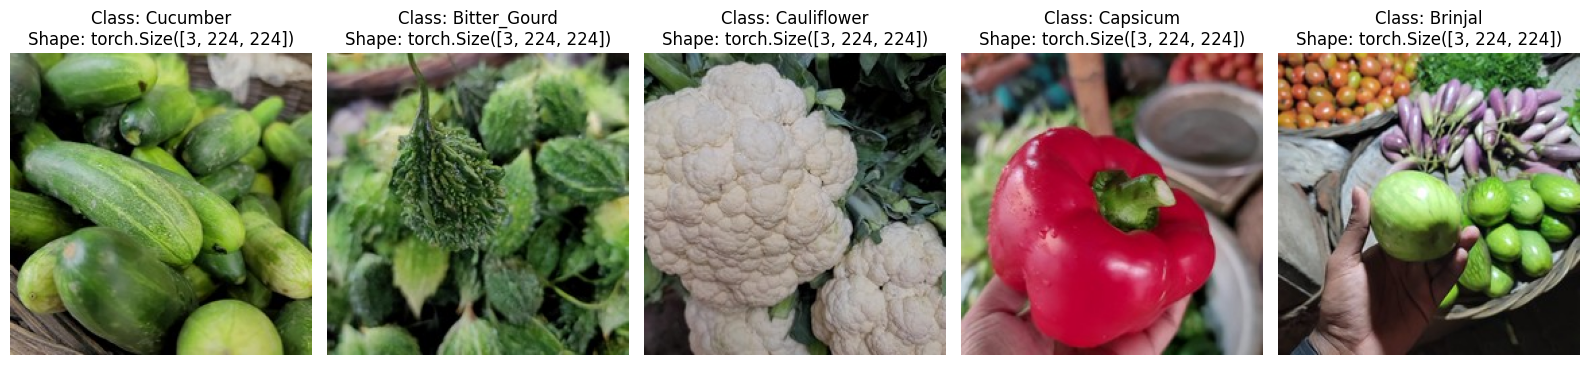

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from IPython.display import display, HTML

def plot_random_images(dataset, num_images=5):
    display(HTML('<H2 style="color:green"> <b>Data Visualization</b></H2><hr>'))

    plt.figure(figsize=(16, 4))
    for i in range(num_images):
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Class: {dataset.classes[label]}\nShape: {image.shape}')
        plt.axis(False)

    plt.tight_layout()
    plt.show()
    display(HTML('<hr>'))

def main():
    # Define the directory containing the dataset
    TRAIN_DIR = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'

    # Define transformations for image preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Load the dataset
    dataset = ImageFolder(root=TRAIN_DIR, transform=transform)

    # Plot random images from the dataset
    plot_random_images(dataset)

if __name__ == "__main__":
    main()


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

# Constants
DATA_DIRECTORY = '/kaggle/input/vegetable-image-dataset/Vegetable Images'
BATCH_SIZE = 64
NUM_WORKERS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations with more augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(30),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

def load_datasets():
    return {x: datasets.ImageFolder(os.path.join(DATA_DIRECTORY, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

def create_dataloaders(image_datasets):
    return {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'validation', 'test']}

def setup_model():
    model = models.vgg16(pretrained=True)  # Use pre-trained weights
    for param in model.parameters():
        param.requires_grad = False  # Freeze pre-trained layers
    num_output_classes = len(image_datasets['train'].classes)
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(0.5),  # Increased dropout
        nn.Linear(512, num_output_classes)  # Adding a new layer for classification
    )
    return model.to(device)

def train_model(model, criterion, optimizer, scheduler, num_epochs=20):  # Increased number of epochs
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc

    print('Best validation Acc: {:4f}'.format(best_acc))

# Usage
image_datasets = load_datasets()
dataloaders = create_dataloaders(image_datasets)
model = setup_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Reduced learning rate

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(model, criterion, optimizer, scheduler, num_epochs=10)  # Increased number of epochs


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also u

Epoch 1/10
----------
train Loss: 1.5412 Acc: 0.5687
validation Loss: 0.2917 Acc: 0.9167
Epoch 2/10
----------
train Loss: 1.3168 Acc: 0.6104
validation Loss: 0.2196 Acc: 0.9407
Epoch 3/10
----------
train Loss: 1.2854 Acc: 0.6259
validation Loss: 0.2309 Acc: 0.9410
Epoch 4/10
----------
train Loss: 1.2962 Acc: 0.6376
validation Loss: 0.2127 Acc: 0.9447
Epoch 5/10
----------
train Loss: 1.3137 Acc: 0.6326
validation Loss: 0.1634 Acc: 0.9563
Epoch 6/10
----------
train Loss: 1.2904 Acc: 0.6453
validation Loss: 0.2090 Acc: 0.9470
Epoch 7/10
----------
train Loss: 1.3222 Acc: 0.6393
validation Loss: 0.2274 Acc: 0.9460
Epoch 8/10
----------
train Loss: 1.1719 Acc: 0.6622
validation Loss: 0.1563 Acc: 0.9587
Epoch 9/10
----------
train Loss: 1.0372 Acc: 0.7003
validation Loss: 0.1612 Acc: 0.9560
Epoch 10/10
----------
train Loss: 1.0067 Acc: 0.7075
validation Loss: 0.1475 Acc: 0.9597
Best validation Acc: 0.959667


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Accuracy: 0.9620
Precision: 0.9645
Recall: 0.9620
F1 Score: 0.9623
Mean Loss: 0.1579


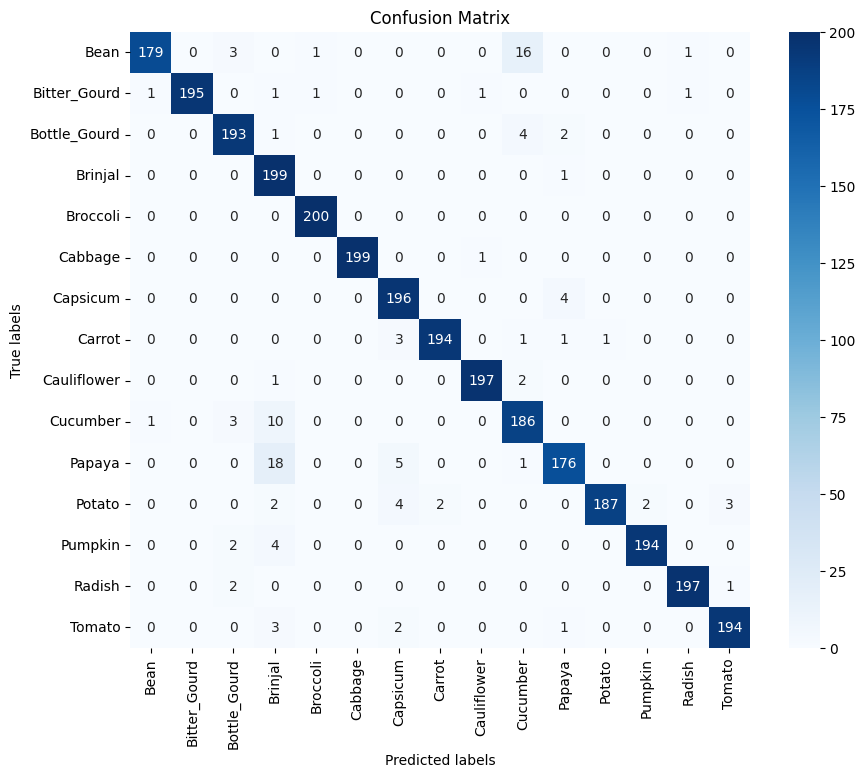

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mean_loss = np.mean(losses)

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Mean Loss: {mean_loss:.4f}')

    return y_true, y_pred

# Evaluate the model
y_true, y_pred = evaluate_model(model, dataloaders['test'])

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
class_names = image_datasets['test'].classes
plot_confusion_matrix(conf_matrix, class_names)
